In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
df_diet = pd.read_csv('Results_21Mar2022.csv')

In [3]:
# 1. Check for missing values
missing_values = df_diet.isnull().sum()

# 2. Check for duplicate rows
duplicate_rows = df_diet.duplicated().sum()

# 3. Basic description for numeric columns to detect outliers
description = df_diet.describe()

# 4. Check skewness of numeric columns
skewness = df_diet.select_dtypes(include='number').skew()

# Summarize everything
{
    "Missing Values": missing_values[missing_values > 0],
    "Number of Duplicate Rows": duplicate_rows,
    "Description (for outlier detection)": description,
    "Skewness": skewness
}


{'Missing Values': Series([], dtype: int64),
 'Number of Duplicate Rows': 0,
 'Description (for outlier detection)':           mc_run_id     mean_ghgs     mean_land  mean_watscar      mean_eut  \
 count  72000.000000  72000.000000  72000.000000  72000.000000  72000.000000   
 mean     500.500000      6.173568     10.610860  18324.502556     24.619412   
 std      288.676995      3.090398      8.774950   5761.426137     10.440526   
 min        1.000000      1.878054      3.085156   5581.200606      7.403603   
 25%      250.750000      4.272191      5.833910  14473.366153     17.490146   
 50%      500.500000      5.460742      7.634004  17340.934265     22.741543   
 75%      750.250000      7.498673     11.766317  20962.489797     30.143916   
 max     1000.000000     20.543958     74.490099  57642.741520     85.043624   
 
        mean_ghgs_ch4  mean_ghgs_n2o      mean_bio   mean_watuse     mean_acid  \
 count   72000.000000   72000.000000  72000.000000  72000.000000  72000.000000  

In [4]:
df_diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mc_run_id       72000 non-null  int64  
 1   grouping        72000 non-null  object 
 2   mean_ghgs       72000 non-null  float64
 3   mean_land       72000 non-null  float64
 4   mean_watscar    72000 non-null  float64
 5   mean_eut        72000 non-null  float64
 6   mean_ghgs_ch4   72000 non-null  float64
 7   mean_ghgs_n2o   72000 non-null  float64
 8   mean_bio        72000 non-null  float64
 9   mean_watuse     72000 non-null  float64
 10  mean_acid       72000 non-null  float64
 11  sd_ghgs         72000 non-null  float64
 12  sd_land         72000 non-null  float64
 13  sd_watscar      72000 non-null  float64
 14  sd_eut          72000 non-null  float64
 15  sd_ghgs_ch4     72000 non-null  float64
 16  sd_ghgs_n2o     72000 non-null  float64
 17  sd_bio          72000 non-null 

In [5]:
# Dictionary to rename diet group labels
diet_rename_map = {
    'meat': 'Low meat-eaters ',
    'meat50': 'Medium meat-eaters',
    'meat100': 'High meat-eaters',
    'vegan': 'Vegan',
    'veggie': 'Vegetarians',
    'fish': 'Fish eaters'
}

# Apply renaming
df_diet['diet_group_clean'] = df_diet['diet_group'].replace(diet_rename_map)


In [6]:
df_diet[['diet_group', 'diet_group_clean']]

,diet_group,diet_group_clean
0,fish,Fish eaters
1,fish,Fish eaters
2,fish,Fish eaters
3,fish,Fish eaters
4,fish,Fish eaters
...,...,...
71995,veggie,Vegetarians
71996,veggie,Vegetarians
71997,veggie,Vegetarians
71998,veggie,Vegetarians


## Visualization

### Radar Chart

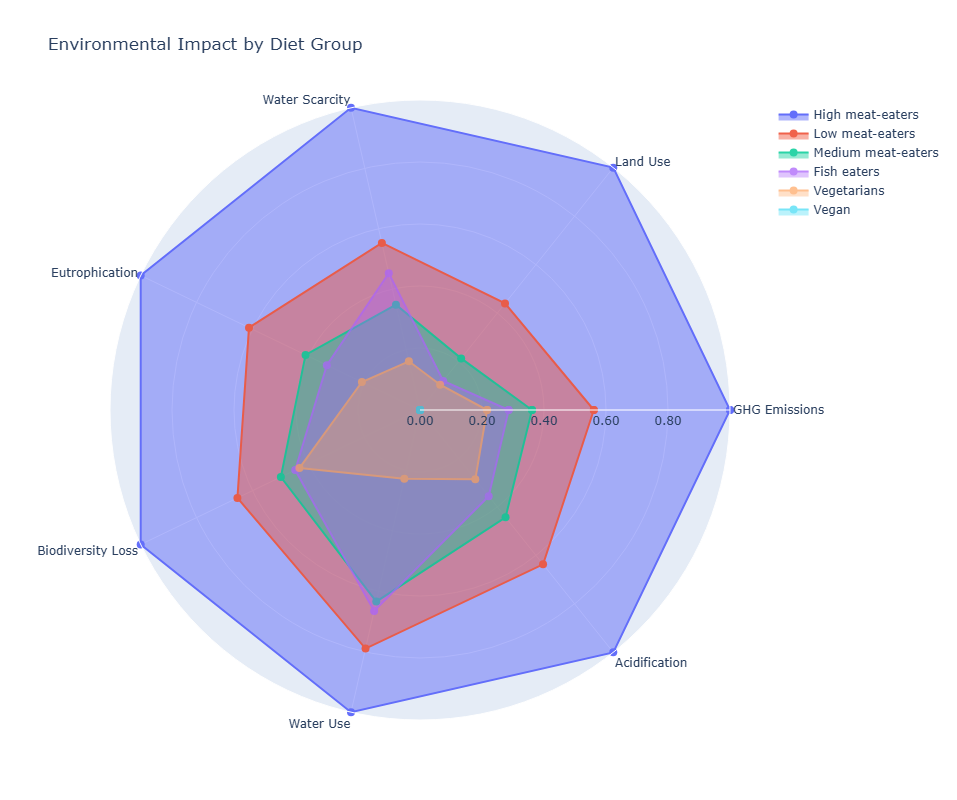

In [9]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Group and normalize data
impact_columns = ['mean_ghgs', 'mean_land', 'mean_watscar', 'mean_eut', 'mean_bio', 'mean_watuse', 'mean_acid']
grouped_df = df_diet.groupby('diet_group_clean')[impact_columns].mean()

# Normalize to 0-1
normalized_df = (grouped_df - grouped_df.min()) / (grouped_df.max() - grouped_df.min())

# Sort by total impact
normalized_df['total_impact'] = normalized_df.sum(axis=1)
sorted_df = normalized_df.sort_values(by='total_impact', ascending=False)
sorted_df.drop(columns='total_impact', inplace=True)

# Renamed labels
label_renames = {
    'mean_ghgs': 'GHG Emissions',
    'mean_land': 'Land Use',
    'mean_watscar': 'Water Scarcity',
    'mean_eut': 'Eutrophication',
    'mean_bio': 'Biodiversity Loss',
    'mean_watuse': 'Water Use',
    'mean_acid': 'Acidification'
}
categories = [label_renames[col] for col in impact_columns]
categories += categories[:1]  # Close loop for radar

# Create radar chart
fig = go.Figure()

for i, (group, row) in enumerate(sorted_df.iterrows()):
    values = row.tolist()
    values += values[:1]  # Close the loop

    opacity = 1 - (i * 0.5 / len(sorted_df))  # Reduce opacity for less impactful diets

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        name=group,
        opacity=opacity,
        fill='toself',
        hoverinfo='text+name',
        mode='lines+markers',
        marker=dict(symbol='circle', size=8),
        line=dict(width=2)
    ))

# Customize layout
fig.update_layout(
    width=800,
    height=800,
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickvals=[0.0, 0.2, 0.4, 0.6, 0.8],
            ticktext=["0.00", "0.20", "0.40", "0.60", "0.80"]
        )
    ),
    title="Environmental Impact by Diet Group",
    showlegend=True,
    legend=dict(itemclick="toggle", itemdoubleclick="toggleothers")
)

fig.show()